In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

%matplotlib inline

In [2]:
train = pd.read_csv('../data/processed/train.csv')
print('shape: ', train.shape)
print('columns', train.columns)

shape:  (20631, 68)
columns Index(['id', 'cycle', 'setting1', 'setting2', 's1', 's2', 's3', 's4', 's5',
       's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16',
       's17', 's20', 's21', 'RUL', 'label1', 'label2', 'avg_setting1',
       'std_setting1', 'avg_setting2', 'std_setting2', 'avg_s1', 'std_s1',
       'avg_s2', 'std_s2', 'avg_s3', 'std_s3', 'avg_s4', 'std_s4', 'avg_s5',
       'std_s5', 'avg_s6', 'std_s6', 'avg_s7', 'std_s7', 'avg_s8', 'std_s8',
       'avg_s9', 'std_s9', 'avg_s10', 'std_s10', 'avg_s11', 'std_s11',
       'avg_s12', 'std_s12', 'avg_s13', 'std_s13', 'avg_s14', 'std_s14',
       'avg_s15', 'std_s15', 'avg_s16', 'std_s16', 'avg_s17', 'std_s17',
       'avg_s20', 'std_s20', 'avg_s21', 'std_s21'],
      dtype='object')


In [3]:
test = pd.read_csv('../data/processed/test.csv')
print('shape: ', test.shape)
print('columns', test.columns)

shape:  (13096, 68)
columns Index(['id', 'cycle', 'setting1', 'setting2', 's1', 's2', 's3', 's4', 's5',
       's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16',
       's17', 's20', 's21', 'RUL', 'label1', 'label2', 'avg_setting1',
       'std_setting1', 'avg_setting2', 'std_setting2', 'avg_s1', 'std_s1',
       'avg_s2', 'std_s2', 'avg_s3', 'std_s3', 'avg_s4', 'std_s4', 'avg_s5',
       'std_s5', 'avg_s6', 'std_s6', 'avg_s7', 'std_s7', 'avg_s8', 'std_s8',
       'avg_s9', 'std_s9', 'avg_s10', 'std_s10', 'avg_s11', 'std_s11',
       'avg_s12', 'std_s12', 'avg_s13', 'std_s13', 'avg_s14', 'std_s14',
       'avg_s15', 'std_s15', 'avg_s16', 'std_s16', 'avg_s17', 'std_s17',
       'avg_s20', 'std_s20', 'avg_s21', 'std_s21'],
      dtype='object')


In [4]:
# Select feature columns
features = test.columns
features = features[(features != 'id') & (features != 'RUL') & (features != 'label1') & (features != 'label2')]

In [5]:
X = train[features].values
y = train['RUL'].values

# normalize data (we haven't ensured that MinMaxScaler is the best scaler for our data)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
def plot_learning_curve_regression(model, title, X, y, scoring, cv=10, n_jobs=-1):
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = cv, test_size = 0.2, random_state = 0)
    # Create 10 KFold cross-validation sets
    #cv = cv

    # Generate the training set sizes increasing by 5%
    train_sizes = np.linspace(.1, 1.0, 5)
    
    # Note: Scoring parameter is needed to have proper scale 
    #       and values on the y scale.
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    #print("Train sizes:", train_sizes)
    #print("Train scores:", train_scores)
    #print("Test scores:", test_scores)
    
    plt.figure(figsize=(6,4))
    plt.title(title)
    plt.xlabel("Number of training examples")
    plt.ylabel("Score: " + scoring)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Testing score")

    plt.legend(loc="best")
    return plt, test_scores


def train_and_predict(model, X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    model.fit(X_train, y_train)    
    y_pred = model.predict(X_test) 
    return mean_absolute_error(y_test, y_pred)


def train_and_cross_val_score(model, X, y, scoring, cv=2):
    return cross_val_score(model, X, y, scoring=scoring, cv=cv)


def train_predict_learning_curve(models, X, y, cv=10):
    for name, model in models:
        print("\nModel: ", name)
        score = (-1)*train_and_predict(model, X, y, test_size=0.2)
        print("Mean absolute error: %0.2f (+/- %0.2f)" % (score, score.std()))
        
        scoring = 'neg_mean_absolute_error'
        scores = train_and_cross_val_score(model, X, y, scoring, cv)
        #print("CV scores: ", scores)
        print("Mean absolute error (cross val.): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

        plt, scores = plot_learning_curve_regression(model, "Learning Performances ({0})".format(name), 
                                             X, y, scoring, cv=10)
        last_scores = scores[-1]
        print("Mean absolute error (last learning perf.): %0.2f (+/- %0.2f)" % (last_scores.mean(), last_scores.std()))
        plt.show();

### Regression

#### Dummy Regressor


Model:  dummy-mean
Mean absolute error: -55.88 (+/- 0.00)
Mean absolute error (cross val.): -56.95 (+/- 6.34)
Mean absolute error (last learning perf.): -56.52 (+/- 0.47)


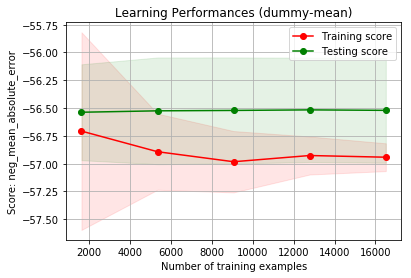


Model:  dummy-median
Mean absolute error: -55.69 (+/- 0.00)
Mean absolute error (cross val.): -56.79 (+/- 6.70)
Mean absolute error (last learning perf.): -56.39 (+/- 0.51)


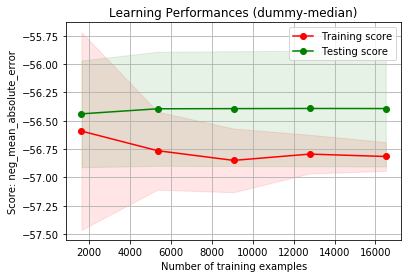

In [7]:
models = [
    ('dummy-mean', DummyRegressor(strategy='mean')),
    ('dummy-median', DummyRegressor(strategy='median'))
]

train_predict_learning_curve(models, X, y)

#### Decision Tree Regression

In [8]:
# Finding best model in a stochastic way
def objective(space):
    
    params = {
        'criterion': space['criterion'],
        'max_depth': space['max_depth'],
        'max_features': space['max_features'],
        'max_leaf_nodes': space['max_leaf_nodes'],
        'min_impurity_decrease': space['min_impurity_decrease'],
        'min_impurity_split': space['min_impurity_split'],
        'min_samples_leaf': space['min_samples_leaf'],
        'min_samples_split': space['min_samples_split'],
        'min_weight_fraction_leaf': space['min_weight_fraction_leaf'],
        'presort': space['presort'],
        'random_state': space['random_state'],
        'splitter': space['splitter']
    }
    
    model = DecisionTreeRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    loss = mean_absolute_error(y_test, y_pred)
    print("LOSS: {0}".format(loss))
    return{'loss':loss, 'status': STATUS_OK }
    
space = {    
    'criterion': 'mse', 
    'max_depth': hp.quniform ('max_depth', 1, 32, 1),
    'max_features': None,
    'max_leaf_nodes': None, 
    'min_impurity_decrease': 0.0,
    'min_impurity_split': None, 
    'min_samples_leaf': 1,
    'min_samples_split': hp.choice('min_samples_split', np.arange(2, 10, dtype=int)), 
    'min_weight_fraction_leaf': 0.0,
    'presort': False, 
    'random_state': 42, 
    'splitter': 'best'
}

trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)
print("\nThe best params:\n", space_eval(space, best_params))

# check model performance for the best set of parameters
best_model = DecisionTreeRegressor(**space_eval(space, best_params))
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print("The LOSS the best params: ", mean_absolute_error(y_test, y_pred))

LOSS: 22.982655739785617
LOSS: 22.982655739785617
LOSS: 24.780620610108908
LOSS: 22.982655739785617
LOSS: 22.82086871815395
LOSS: 22.958125606000703
LOSS: 28.90894547980971
LOSS: 22.657345164278734
LOSS: 23.17421460314613
LOSS: 23.434890208904633

The best params:
 {'criterion': 'mse', 'max_depth': 20.0, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 42, 'splitter': 'best'}
The LOSS the best params:  22.657345164278734



Model:  best Decision Tree model
Mean absolute error: -22.66 (+/- 0.00)
Mean absolute error (cross val.): -34.87 (+/- 4.39)
Mean absolute error (last learning perf.): -23.32 (+/- 0.58)


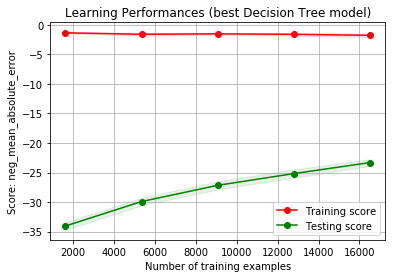

In [9]:
models = [
    ('best Decision Tree model', best_model)
]
train_predict_learning_curve(models, X, y, cv=5)

#### Random Forest Regression

In [11]:
# Finding best model in a stochastic way
def objective(space):
    
    params = {
        'bootstrap': space['bootstrap'], 
        'criterion': space['criterion'], 
        'max_depth': space['max_depth'],
        'max_features': space['max_features'], 
        'max_leaf_nodes': space['max_leaf_nodes'],
        'min_impurity_decrease': space['min_impurity_decrease'], 
        'min_impurity_split': space['min_impurity_split'],
        'min_samples_leaf': space['min_samples_leaf'], 
        'min_samples_split': space['min_samples_split'],
        'min_weight_fraction_leaf': space['min_weight_fraction_leaf'], 
        'n_estimators': space['n_estimators'], 
        'n_jobs': space['n_jobs'],
        'oob_score': space['oob_score'], 
        'random_state': space['random_state'], 
        'verbose': space['verbose'], 
        'warm_start': space['warm_start']
    }
    
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    loss = mean_absolute_error(y_test, y_pred)
    print("LOSS: {0}".format(loss))
    return{'loss':loss, 'status': STATUS_OK }
    
space = {    
    'bootstrap': True, 
    'criterion': 'mse', 
    'max_depth': hp.quniform ('max_depth', 1, 32, 1),
    'max_features': 'auto', 
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0, 
    'min_impurity_split': None,
    'min_samples_leaf': 1, 
    'min_samples_split': hp.choice('min_samples_split', np.arange(2, 10, dtype=int)),
    'min_weight_fraction_leaf': 0.0, 
    'n_estimators': hp.choice('n_estimators', np.arange(8, 32, dtype=int)), # number of trees 
    'n_jobs': -1, # use all CPU cores
    'oob_score': False, 
    'random_state': 42, 
    'verbose': 0, 
    'warm_start': False
}

trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)
print("\nThe best params:\n", space_eval(space, best_params))

# check model performance for the best set of parameters
best_model = RandomForestRegressor(**space_eval(space, best_params))
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print("The LOSS the best params: ", mean_absolute_error(y_test, y_pred))

LOSS: 38.71711518416128
LOSS: 30.410013637053343
LOSS: 19.23183469200298
LOSS: 19.20275848960874
LOSS: 19.846683615274014
LOSS: 20.02828187671868
LOSS: 19.398067182902377
LOSS: 19.32478772018765
LOSS: 19.52349097296113
LOSS: 22.72255486912775

The best params:
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': 31.0, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 18, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
The LOSS the best params:  19.20275848960874



Model:  best Random Forest model
Mean absolute error: -19.20 (+/- 0.00)
Mean absolute error (cross val.): -27.61 (+/- 5.09)
Mean absolute error (last learning perf.): -19.42 (+/- 0.31)


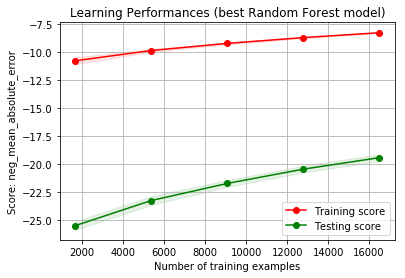

In [12]:
models = [
    ('best Random Forest model', best_model)
]
train_predict_learning_curve(models, X, y, cv=5)

#### Boosted Trees Regression

In [13]:
# Finding best model in a stochastic way
def objective(space):
    
    params = {
        'base_score': space['base_score'],
        'booster': space['booster'],
        'colsample_bylevel': space['colsample_bylevel'],
        'colsample_bytree': space['colsample_bytree'],
        'gamma': space['gamma'],
        'learning_rate': space['learning_rate'],
        'max_delta_step': space['max_delta_step'],
        'max_depth': space['max_depth'],
        'min_child_weight': space['min_child_weight'],
        'missing': space['missing'],
        'n_estimators': space['n_estimators'],
        'n_jobs': space['n_jobs'],
        'nthread': space['nthread'],
        'objective': space['objective'],
        'random_state': space['random_state'],
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'scale_pos_weight': space['scale_pos_weight'],
        'seed': space['seed'],
        'silent': space['silent'],
        'subsample': space['subsample']
    }
    
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    loss = mean_absolute_error(y_test, y_pred)
    print("LOSS: {0}".format(loss))
    return{'loss':loss, 'status': STATUS_OK }
    
space = {    
    'base_score': 0.5, 
    'booster': 'gbtree', 
    'colsample_bylevel': 1,
    'colsample_bytree': 1, 
    'gamma': 0, 
    'learning_rate': 0.1, 
    'max_delta_step': 0,
    'max_depth': hp.choice('max_depth', np.arange(2, 16, dtype=int)), 
    'min_child_weight': 1, 
    'missing': None, 
    'n_estimators': hp.choice('n_estimators', np.arange(8, 100, dtype=int)), # number of trees,
    'n_jobs': -1, 
    'nthread': None, 
    'objective': 'reg:linear', 
    'random_state': 42,
    'reg_alpha': 0, 
    'reg_lambda': 1, 
    'scale_pos_weight': 1, 
    'seed': None,
    'silent': True, 
    'subsample': 1
}

trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)
print("\nThe best params:\n", space_eval(space, best_params))

# check model performance for the best set of parameters
best_model = XGBRegressor(**space_eval(space, best_params))
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print("The LOSS the best params: ", mean_absolute_error(y_test, y_pred))

LOSS: 28.126095001825213
LOSS: 28.126095001825213
LOSS: 24.748111520476165
LOSS: 24.748111520476165
LOSS: 16.07102488555052
LOSS: 16.3103544016294
LOSS: 17.538499434006713
LOSS: 24.071886821147864
LOSS: 27.5393162996104
LOSS: 16.2068346310592

The best params:
 {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 82, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
The LOSS the best params:  16.07102488555052



Model:  best XGBoost model
Mean absolute error: -16.07 (+/- 0.00)
Mean absolute error (cross val.): -27.60 (+/- 5.80)
Mean absolute error (last learning perf.): -16.17 (+/- 0.28)


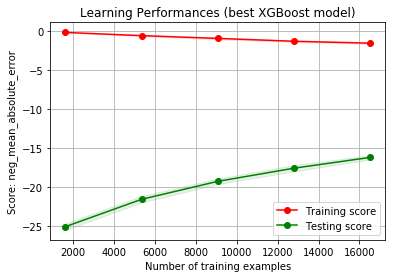

In [14]:
models = [
    ('best XGBoost model', best_model)
]
train_predict_learning_curve(models, X, y, cv=5)

In [15]:
# TODO:
# * get more familiar with XGBoost and available hyperparameters